# Census Bureau: Business Formation Statistics Weekly Data at the State Level

In [3]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# load the data
census_df = pd.read_csv('bfs_state_apps_weekly_nsa.csv')

## 1. Exploratory Data Analysis

How many rows are there? How many columns?

In [5]:
print(f"There are {len(census_df)} rows in the dataset")
print(f"The columns in the dataset are: ")
for col in census_df.columns:
    print('\t*', col)

There are 51153 rows in the dataset
The columns in the dataset are: 
	* Year
	* Week
	* State
	* BA_NSA
	* HBA_NSA
	* WBA_NSA
	* CBA_NSA
	* YY_BA_NSA
	* YY_HBA_NSA
	* YY_WBA_NSA
	* YY_CBA_NSA


Use the [data dictionary](https://www.census.gov/econ/bfs/pdf/bfs_weekly_data_dictionary.pdf) to understand what information each column contains:

* Year: Four digit year
* Week: Week of the year based on IRS processing. Leap years have 53 weeks
* State: two-letter state abbreviations, including the District of Columbia
* BA_NSA: Not seasonally adjusted business application
* HBA_BSA: Not seasonally adjusted high-propensity business application
* WBA_NSA: Not seasonally adjusted business applications with planned wage
* CBA_NSA: Not seasonally adjusted business applications from corporations
* YY_BA_NSA: Calculated year-to-year percentage changes for same week a year ago for the business application series. No values exist for 2006 or the 53rd week of leap years.
* YY_HBA_NSA: Calculated year-to-year percentage changes for same week a year ago for the high-propensity business application series. No values exist for 2006 or the 53rd week of leap years.
* YY_WBA_NSA: Calculated year-to-year percentage changes for same week a year ago for the business applications with planned wages series. No values exist for 2006 or the 53rd week of leap years.
* YY_CBA_NSA: Calculated year-to-year percentage changes for same week a year ago for the business applications from corporations series. No values exist for 2006 or the 53rd week of leap years.

In [6]:
# Now let's look at the quality of the data
census_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51153 entries, 0 to 51152
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Year        51153 non-null  int64  
 1   Week        51153 non-null  int64  
 2   State       51153 non-null  object 
 3   BA_NSA      51153 non-null  int64  
 4   HBA_NSA     51153 non-null  int64  
 5   WBA_NSA     51153 non-null  int64  
 6   CBA_NSA     51153 non-null  int64  
 7   YY_BA_NSA   48399 non-null  float64
 8   YY_HBA_NSA  48399 non-null  float64
 9   YY_WBA_NSA  48399 non-null  float64
 10  YY_CBA_NSA  48399 non-null  float64
dtypes: float64(4), int64(6), object(1)
memory usage: 4.3+ MB


In [7]:
# Now let's look at the quality of the data
census_df.describe()

,Year,Week,BA_NSA,HBA_NSA,WBA_NSA,CBA_NSA,YY_BA_NSA,YY_HBA_NSA,YY_WBA_NSA,YY_CBA_NSA
count,51153.000000,51153.000000,51153.000000,51153.000000,51153.000000,51153.000000,48399.000000,48399.00,48399.00,48399.00
mean,2015.121635,26.300100,1293.205873,515.571325,218.898989,231.573515,7.064424,inf,inf,inf
std,5.557258,15.111455,1762.593845,737.978938,279.582850,442.654363,38.641677,NaN,NaN,NaN
min,2006.000000,1.000000,10.000000,0.000000,0.000000,0.000000,-93.130000,-100.00,-100.00,-100.00
25%,2010.000000,13.000000,290.000000,110.000000,60.000000,40.000000,-7.140000,-11.11,-15.79,-16.67
50%,2015.000000,26.000000,750.000000,280.000000,130.000000,80.000000,2.500000,0.00,0.00,0.00
75%,2020.000000,39.000000,1460.000000,550.000000,250.000000,200.000000,13.640000,12.50,10.71,11.11
max,2025.000000,53.000000,19040.000000,6630.000000,3480.000000,4110.000000,1200.000000,inf,inf,inf


* We can use the Min and Mix rows to see that this data ranges from 2006 all the way to 2025, which is just over 18 years' worth of data! With 52 weeks in a year, and 51 states being recorded, we have a good amount of variety here to be able to train a model! 

* It looks like there are some null values in our code causing some division by zero values in the descriptive statistics. The Year-to-Year columns display both 'inf' and 'NaN' values. Let's see if we can find out more about when these are occurring in the data. 

In [8]:
census_df.isnull().sum()

Year             0
Week             0
State            0
BA_NSA           0
HBA_NSA          0
WBA_NSA          0
CBA_NSA          0
YY_BA_NSA     2754
YY_HBA_NSA    2754
YY_WBA_NSA    2754
YY_CBA_NSA    2754
dtype: int64

* It makes sense that there are missing values in these year over year calculations because we were told in the data dictionary that the year 2006, and the 53rd week of each leap year do not have corresponding values. How many missing values remain in the data if we exclude 2006? 

In [9]:
census_df[census_df['Year'] > 2006].isnull().sum()

Year            0
Week            0
State           0
BA_NSA          0
HBA_NSA         0
WBA_NSA         0
CBA_NSA         0
YY_BA_NSA     102
YY_HBA_NSA    102
YY_WBA_NSA    102
YY_CBA_NSA    102
dtype: int64

Just by excluding the year 2006, we go from two thousand missing values down to 102. This is very promising. Seeing as there are 51 states, and 102 / 51 = 2, there are likely two leap years remaining in the data for which the 53rd weeks have missing values. While leap years add a single day to the calendar every four years, adding an entire extra week to the data will likely skew the results rather than provide an additional layer of complexity. 

#### Remianing cleaning steps:
* remove the 53rd weeks from the dataset
* remove the data from 2025 since it is still a mostly incomplete year in the dataset

In [10]:
census_df_clnd = census_df.loc[(census_df['Year'] > 2006) & (census_df['Year'] < 2025) & (census_df['Week'] != 53)]
census_df_clnd.isnull().sum()

Year          0
Week          0
State         0
BA_NSA        0
HBA_NSA       0
WBA_NSA       0
CBA_NSA       0
YY_BA_NSA     0
YY_HBA_NSA    0
YY_WBA_NSA    0
YY_CBA_NSA    0
dtype: int64

* We have successfully removed the null values from the data in a meaningful way. Now we can look more closely at the characteristics of the remaining features to determine if there are any correlations between variables and which column we want to have a machine learning model predict. 

* Let's check the descriptive statistics again to ensure there aren't any other funky things in our dataset now that the missing values have been taken care of...

In [11]:
census_df_clnd.describe()

,Year,Week,BA_NSA,HBA_NSA,WBA_NSA,CBA_NSA,YY_BA_NSA,YY_HBA_NSA,YY_WBA_NSA,YY_CBA_NSA
count,47736.000000,47736.000000,47736.000000,47736.000000,47736.000000,47736.000000,47736.000000,47736.000,47736.00,47736.00
mean,2015.500000,26.500000,1299.531171,509.688705,211.671694,225.462335,7.223173,inf,inf,inf
std,5.188182,15.008488,1766.208821,730.199623,266.180310,433.026642,38.703593,NaN,NaN,NaN
min,2007.000000,1.000000,10.000000,0.000000,0.000000,0.000000,-92.310000,-100.000,-100.00,-100.00
25%,2011.000000,13.750000,300.000000,110.000000,60.000000,40.000000,-7.040000,-11.110,-15.79,-16.67
50%,2015.500000,26.500000,760.000000,280.000000,130.000000,80.000000,2.580000,0.000,0.00,0.00
75%,2020.000000,39.250000,1470.000000,540.000000,250.000000,190.000000,13.680000,12.455,10.71,10.53
max,2024.000000,52.000000,19040.000000,6630.000000,3480.000000,4050.000000,1200.000000,inf,inf,inf


Uh oh! It looks like we are still getting 'inf' and 'NaN' values in some of our Year over Year columns. This actually helps make the decision of which `YY_` column to choose for our target variable. Since the `YY_BA_NSA` is quite clean, let's plan to use that for the machine learning model. That means we can actualy remove the other columns since they are referring to data series that we will not be using. 

In [12]:
census_df_clnd = census_df_clnd.drop(labels=['YY_HBA_NSA', 'HBA_NSA', 'YY_WBA_NSA', 'WBA_NSA', 'YY_CBA_NSA', 'CBA_NSA'], axis=1, inplace=False)

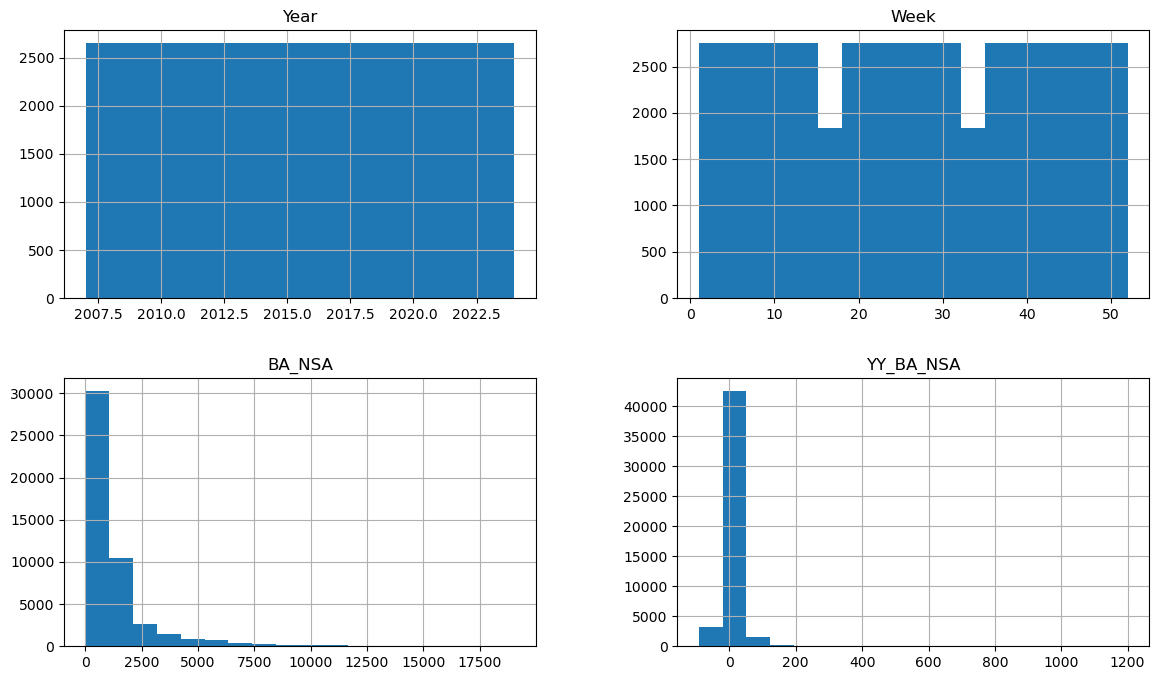

In [13]:
# Plot a histogram of the data to see the distribution of each column
census_df_clnd.hist(bins=18, figsize=(14,8))
plt.show()

#### Histogram Takeaways:
* There is a uniform amount of data present for each Year in the dataset. 
* All the weeks have representation, though the amount of records per value varies by nearly 1,000.  
    * This looks like it could potentially form a good segmentation rule or set of rules in a decision tree.
* As the number of business applications increases, the quanitity of records with that value decreases. In other words, there seems to be a inversely proportional relationship between data values and their frequency. 
* the `YY_BA_NSA` hovers very close to zero. I am curious what this particular column looks like with a box and whisker plot to better see the spread. Right now there is some concern that training a model on this variable with create bias towards always guessing a value around 0. We need to be very carefulto prevent an unbalanced prediction model. 

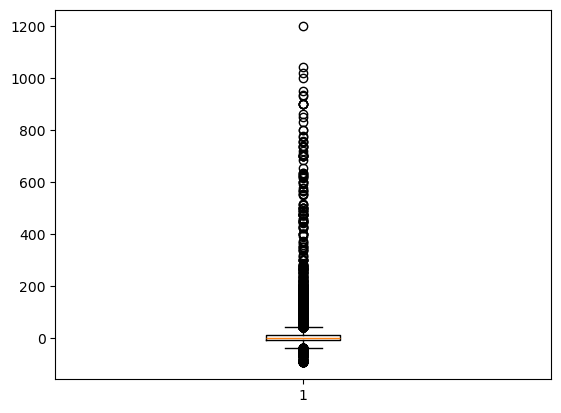

In [14]:
# Plot a box and whisker plot of our target variable
plt.boxplot(census_df_clnd['YY_BA_NSA'])
plt.show()

This box and whisker plot shows a much greater spread of "outliers" that the histogram did not show. That means there is likely enough variance within the data to use this as our target variable, granted we are vigilant about the training and testing split(s) used to ensure that all possible values are considered by the model. 

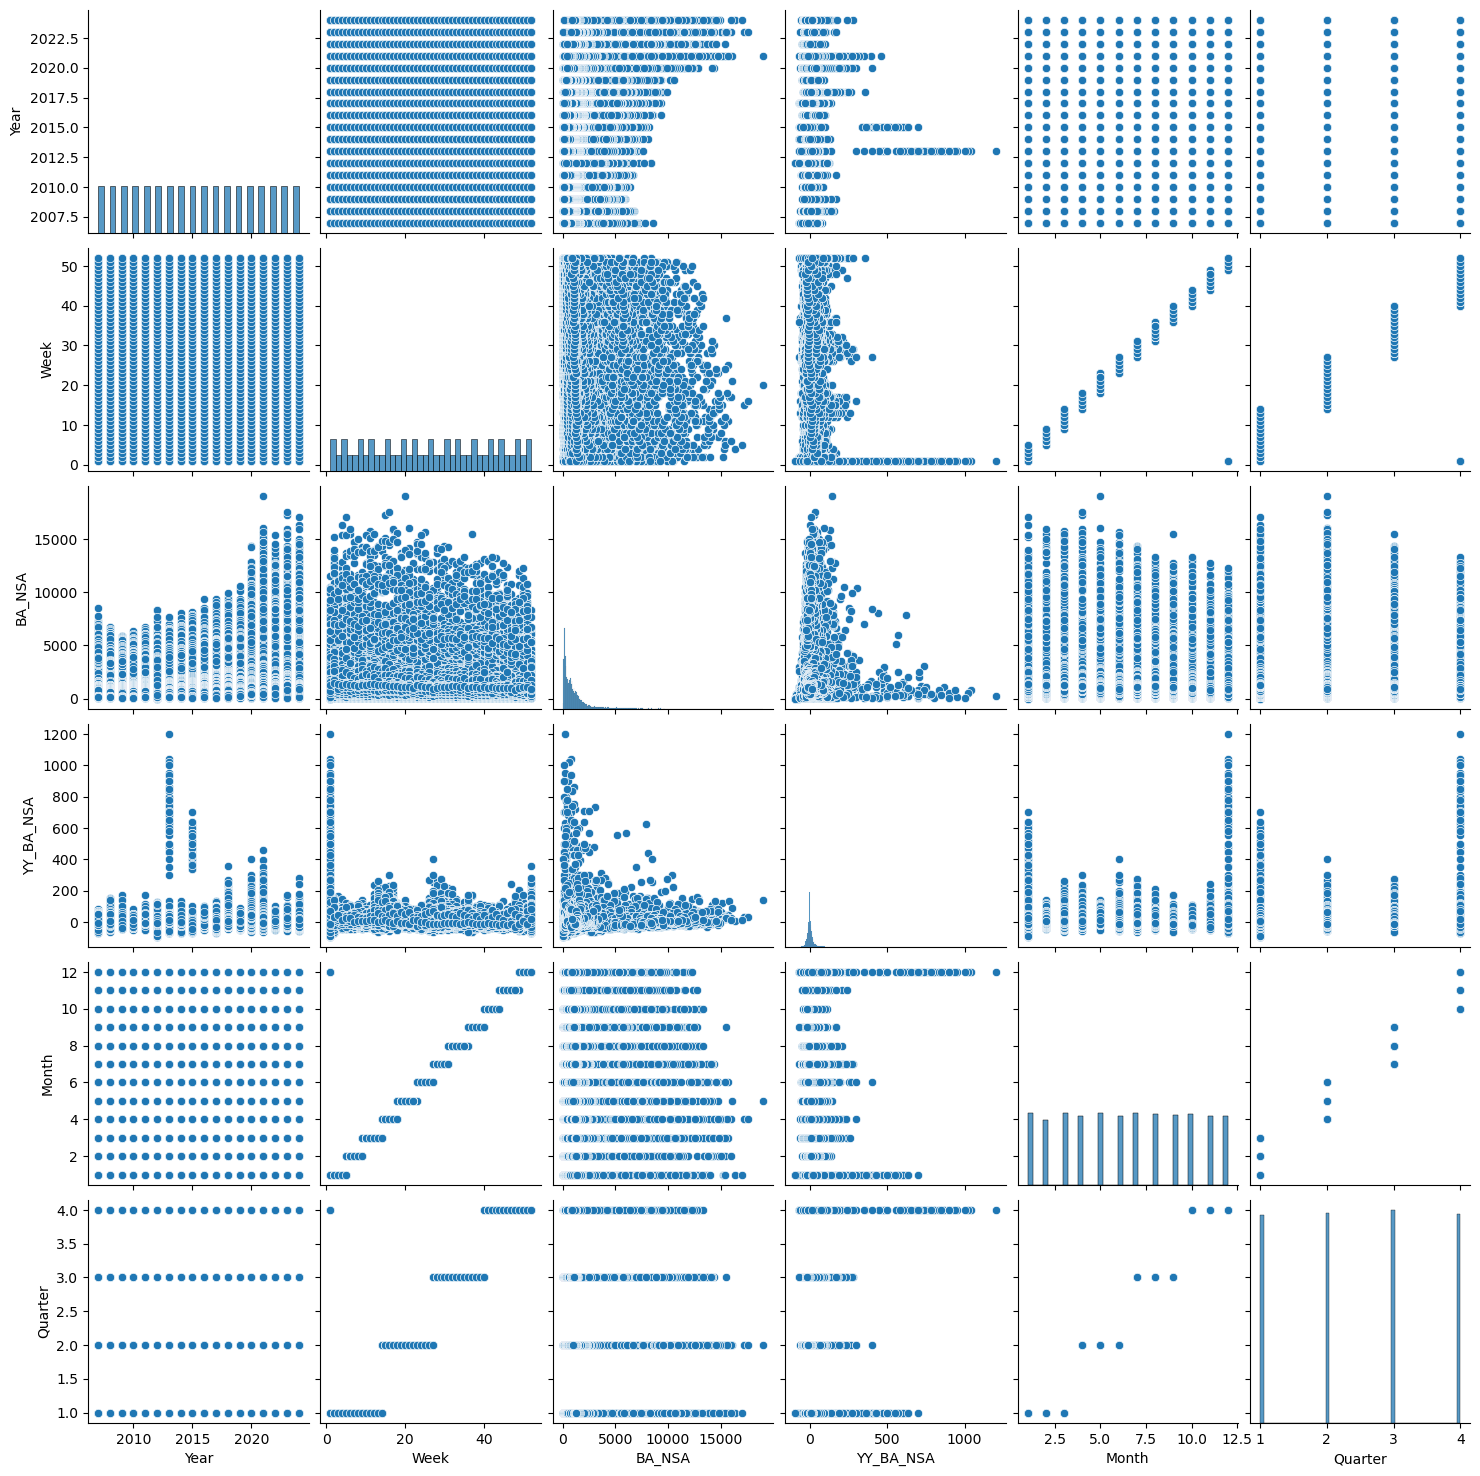

In [22]:
sns.pairplot(full_census_data)
plt.show()


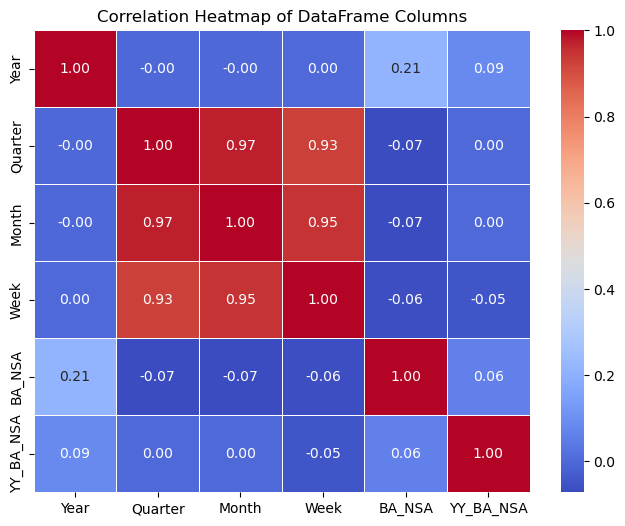

In [24]:
# Calculate the correlation matrix
corr_matrix = full_census_data[['Year', 'Quarter', 'Month', 'Week', 'BA_NSA', 'YY_BA_NSA']].corr()

# Create the heatmap
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of DataFrame Columns')
plt.show()

## 2. Model Data Preparation

Before we actually start exploring models, we want to prepare the data for being turned into training and testing sets. 

In addition to the data from the `bfs_state_apps_weekly_nsa.csv`, the Census Bureau also provided a date lookup table in the `date_table.csv` file both of which can be found [here](https://www.census.gov/econ/bfs/data/weekly.html). Let's join the start and end dates of each week to the dataframe so we can also include months and quarters in the data. 


In [15]:
# Load the date lookup table
date_df = pd.read_csv('date_table.csv')

In [16]:
full_census_data = pd.merge(census_df_clnd, date_df, on=['Year', 'Week'], how='left')

Check out the data to make sure the join worked as expected

In [17]:
full_census_data.head(10)

,Year,Week,State,BA_NSA,YY_BA_NSA,Start date,End date
0,2007,1,AK,100,11.11,12/31/2006,1/6/2007
1,2007,2,AK,40,-55.56,1/7/2007,1/13/2007
2,2007,3,AK,130,0.00,1/14/2007,1/20/2007
3,2007,4,AK,100,0.00,1/21/2007,1/27/2007
4,2007,5,AK,130,-13.33,1/28/2007,2/3/2007
5,2007,6,AK,120,33.33,2/4/2007,2/10/2007
6,2007,7,AK,120,-7.69,2/11/2007,2/17/2007
7,2007,8,AK,140,7.69,2/18/2007,2/24/2007
8,2007,9,AK,80,-27.27,2/25/2007,3/3/2007
9,2007,10,AK,100,-28.57,3/4/2007,3/10/2007


Now let's use the pandas 

In [18]:
full_census_data['Start date'] = pd.to_datetime(full_census_data['Start date'])
full_census_data['End date'] = pd.to_datetime(full_census_data['End date'])

full_census_data['Month'] = full_census_data['Start date'].dt.month
full_census_data['Quarter'] = full_census_data['Start date'].dt.quarter

In [19]:
full_census_data.head()

,Year,Week,State,BA_NSA,YY_BA_NSA,Start date,End date,Month,Quarter
0,2007,1,AK,100,11.11,2006-12-31,2007-01-06,12,4
1,2007,2,AK,40,-55.56,2007-01-07,2007-01-13,1,1
2,2007,3,AK,130,0.00,2007-01-14,2007-01-20,1,1
3,2007,4,AK,100,0.00,2007-01-21,2007-01-27,1,1
4,2007,5,AK,130,-13.33,2007-01-28,2007-02-03,1,1


Now we have the following columns that can be used to train the model(s) to predict the target variable `YY_BA_NSA`:
* `Year`
* `Quarter`
* `Month`
* `Week`
* `BA_NSA`

## 3. Create Training and Evaluation Sets to Build Some Models

For this particular dataset, I believe the best train/test split method will be stratified k-fold cross validation since it maintains the same distribution of classes as the entire dataset. The hope is that the approach will ensure that the target values are more spread out across the entire range of the dataset. 

Another viable option is the Time Series Split, which consists of the next 'n' points in the data and avoids "looking into the future" while training the model. 
[source](https://www.kaggle.com/discussions/general/448072)

There are three different types of models that I would like to try with this data:
1. Decision Tree
2. Multi-linear Regression
3. Ensemble method - random forest with and without the multi-linear regressor

In [32]:
X = full_census_data[['Year', 'Quarter', 'Month', 'Week', 'State', 'BA_NSA']]

y = full_census_data['YY_BA_NSA']

In [33]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error

# skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# for train_index, test_index in skf.split(X, y):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# train and test the model inside the for loop
clf = DecisionTreeRegressor(random_state=3, max_depth=3)
clf.fit(X_train, y_train)

# predictions
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

# Calculate model accuracy by getting the rMSE

rmse_train = root_mean_squared_error(y_train, y_pred_train)
print(f"Training performance: {rmse_train}")
rmse_test = root_mean_squared_error(y_test, y_pred_test)
print(f"Training performance: {rmse_test}")

ValueError: could not convert string to float: 'UT'